In [146]:
import pandas as pd
import jupyterthemes as jt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer 
from fbprophet import Prophet
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import gensim.corpora as corpora
import re
import plotly.express as px
import gensim
import spacy
import plotly.graph_objects as go
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from nltk.corpus import stopwords
import nltk 
sns.set(rc={'figure.figsize':(20,10)})

In [2]:
df = pd.read_excel('online_retail_II.xlsx' , index_col=False)

## Clean Dataset

In [39]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [223]:
df1 = df

In [5]:
def clean_dataset(df):
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df = df[df['Quantity'] > 0]
    df['Price']=df['Price'].astype(str)
    df['Price']=df['Price'].astype(float)
    df = df[df['Price'] > 0]
    df['Month'] = pd.DatetimeIndex(pd.to_datetime(df['InvoiceDate'])).month
    return df

In [36]:
df1 = clean_dataset(df)

/opt/anaconda3/envs/TimeSeries/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/TimeSeries/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Insights

### Price and Quantity

In [111]:
def price_quantity_plot(df):
    df = df[['Quantity','Price']]
    df['PriceBins'] = pd.cut(df['Price'].tolist(), bins=8)
    sns.barplot(data=df,x="PriceBins", y="Quantity")

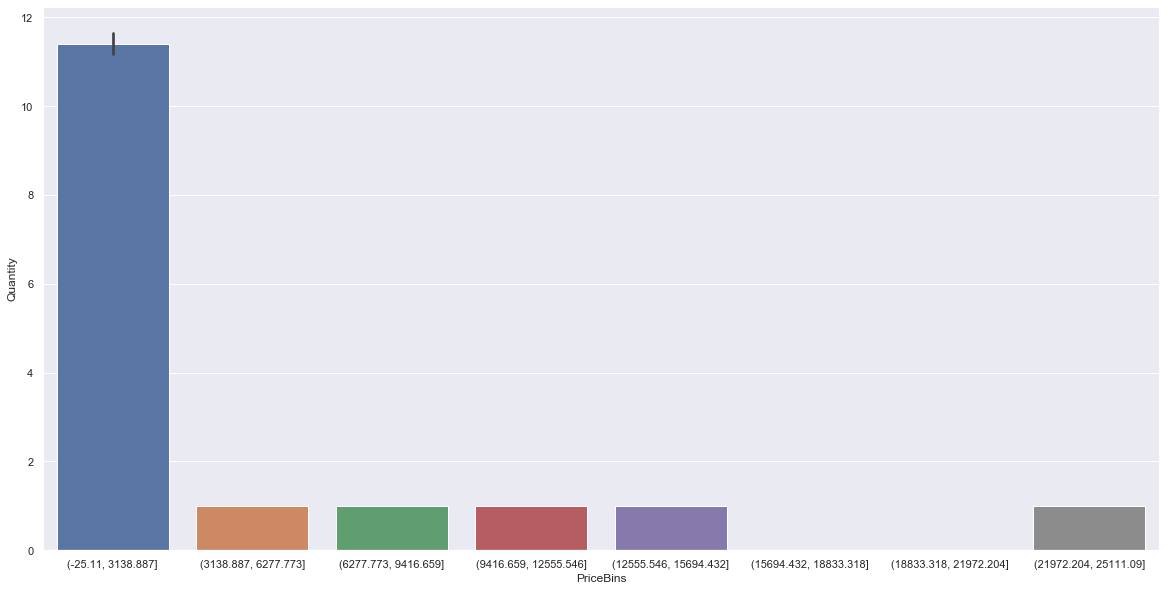

In [112]:
price_quantity_plot(df1)

### Changes of Quantity bought by countries during the last year

In [85]:
def countr_month_quantity(df):
    df = df.groupby(['Country' , 'Month']).agg({'Quantity':'sum'})
    df = df.reset_index()
    df = df.sort_values(by=['Month'])
    Europe = ['United Kingdom','France', 'Belgium','EIRE',
              'Germany','Portugal', 'Denmark', 'Netherlands', 'Poland',
             'Spain', 'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden', 
              'Finland','Italy', 'Switzerland', 'Malta', 'Israel', 
              'Lithuania','Iceland']
    Asia = [ 'Japan','United Arab Emirates','Singapore','Hong Kong',
       'Thailand','West Indies', 'Korea','Lebanon',]
    America = ['Channel Islands','USA','Brazil', 'Canada']
    Australia = ['Australia',]
    df['Continent'] = df['Country'].map(lambda x: 'Europe' if x in Europe else(
                                        'Asia' if x in Asia else
                                        'America' if x in America else
                                        'Australia' if x in Australia else 'None' ))
    fig = px.scatter_geo(df, locations="Country",color="Continent",
                         hover_name="Country", size="Quantity",
                         animation_frame="Month",
                         projection="natural earth")
    fig.show()

In [86]:
countr_month_quantity(df1)

### How many customers bought something each month during the last year 

In [132]:
def price_customer(df):
    
    df = df.groupby(['Country' , 'Month']).agg({'Price':'sum' , 'Customer ID' :'count'})
    df.columns = ['PriceSum','CustomerIDCount']
    df = df.reset_index()
    cm = sns.light_palette("blue", as_cmap=True)
    pvd = pd.pivot_table(df, values='CustomerIDCount', index=['Country'],
                    columns=['Month'],
                    aggfunc=np.sum).fillna(0)
    return pvd.style.background_gradient(cmap=cm)

In [133]:
price_customer(df1)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Country,,,,,,,,,,,,
Australia,0,32,19,17,59,110,18,7,21,141,170,36
Austria,0,56,36,36,34,18,0,62,96,32,116,38
Bahrain,0,0,0,0,22,0,0,0,0,20,0,0
Belgium,92,63,47,115,6,135,104,78,66,78,221,32
Bermuda,0,0,0,0,0,0,0,0,0,0,0,0
Brazil,0,0,0,0,0,0,0,0,62,0,0,0
Canada,0,0,0,0,0,0,0,0,0,50,27,0
Channel Islands,27,0,16,51,213,6,0,50,200,105,97,56
Cyprus,4,49,65,49,18,20,0,0,110,31,4,191


### In what ranges prices are most common

In [134]:
def prices_changes(df):
    prices = pd.DataFrame([df['Price'].value_counts()
                         .sort_values(ascending=False).to_dict()]).T
    df = pd.DataFrame(df['Price'].value_counts())
    df = df.reset_index()
    df.columns = ['Price','CountPrice']
    df['PriceBins'] = pd.cut(df['Price'].tolist(), bins=8)
    sns.barplot(data=df, x='PriceBins', y='CountPrice')

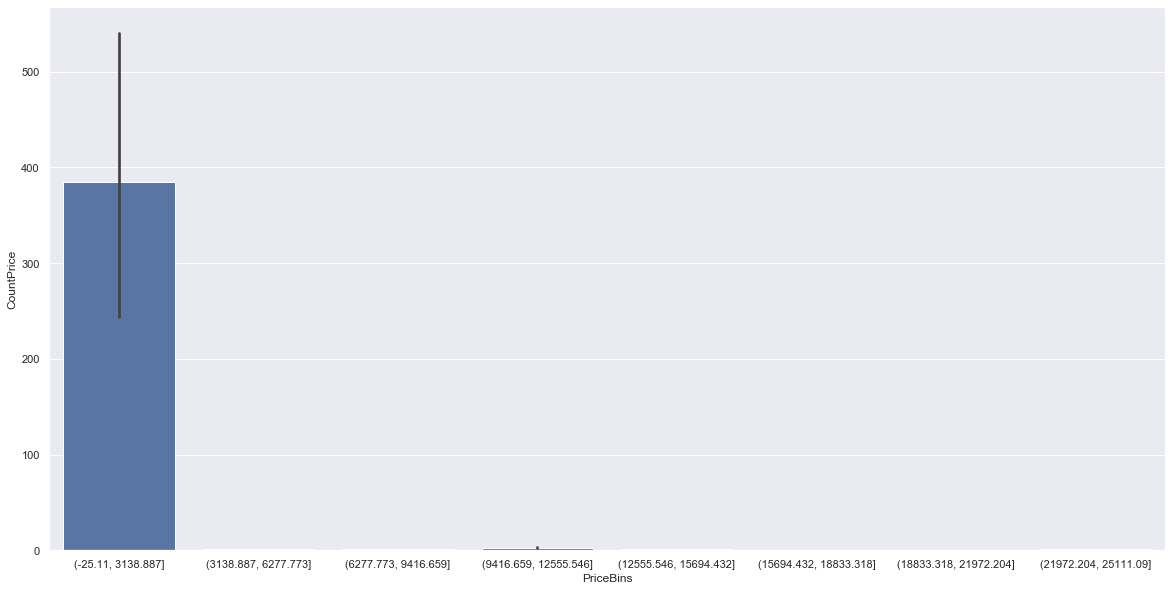

In [135]:
prices_changes(df1)

### Range of price change during time

In [137]:
def EDA(df):
     customer_avg_spending= df[['Price','Customer ID', 'InvoiceDate' , 'Country']]
     avg_selling_of_products = df[['Price','Quantity','InvoiceDate']]
     return customer_avg_spending, avg_selling_of_products 

In [138]:
customer_avg_spending, avg_selling_of_products= EDA(df)

In [156]:
def customer_avg_spending_insights(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y-%m-%d')
    df = df.groupby(['InvoiceDate']).agg({'Price':'sum'}).reset_index()
    df = df.reset_index(drop=True)
    df.columns = ['Date','PriceSum']
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df['PriceSum'], name="Price Sum",
                         line_color='deepskyblue'))
    fig.update_layout(title_text='Sum range of all prices among time',
                  xaxis_rangeslider_visible=True)
    fig.show()

In [157]:
customer_avg_spending_insights(df1)

## NLP

In [164]:
class CleanColumn(BaseEstimator , TransformerMixin):
    def __init__(self):
        pass
    def fit(self ,X , y=None):
        return self
    def transform(self , X):
            description = [re.sub("\'" , "" , sent) for sent in X]
            description = [re.sub("\"" , "" , sent) for sent in description]
            description = [re.sub("\&" , "" , sent) for sent in description]
            description = [re.sub("\+" , "" , sent) for sent in description]
            description = [re.sub("\/" , "" , sent) for sent in description]
            description = [re.sub("\-" , "" , sent) for sent in description]
            description_clean =[re.sub("\d+" , "" , sent) for sent in description]
            return description_clean

In [165]:
class Debug(BaseEstimator , TransformerMixin):
    def fit(self , X , y=None , **fit_params):
        return self
    def transform(self , X):
        print(X.shape)
        return X       

In [173]:
nlp_pipeline = Pipeline([
    ('cleaning', CleanColumn()),
    ('vect', CountVectorizer()),
    ('debug', Debug()),
])

In [174]:
nlp_transformed = nlp_pipeline.fit_transform(df['Description'].astype(str))

(525461, 2323)


## LDA  - create y variable from descriptions

In [175]:
LDA = LatentDirichletAllocation(n_components=5, random_state=42,verbose=True)
LDA.fit(nlp_transformed)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=True)

In [176]:
topic_values = LDA.transform(nlp_transformed)

In [182]:
df['Topic'] = topic_values.argmax(axis=1)

## Modeling


### Prophet

In [217]:
class PrepareDataFrame(BaseException , TransformerMixin):
    def __init__(self , df):
        self.df = df
    def fit(self , df):
        return self
    def transform(self , df):
        df = df[['InvoiceDate', 'Topic', 'Price']]
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y-%m-%d')
        
        df = df.groupby(['InvoiceDate', 'Topic']).agg({'Price':'mean'})
        df = df_modeling.reset_index()
        df_topic_1 = df[df['Topic'] == 1]
        df_topic_2 = df[df['Topic'] == 2]
        df_topic_3 = df[df['Topic'] == 3]
        df_topic_4 = df[df['Topic'] == 4]
        return df_topic_1 , df_topic_2,df_topic_3,df_topic_4

In [218]:
num_pipeline = Pipeline([
    ('preparedf' , PrepareDataFrame(df))
])

In [219]:
df_topic_1 , df_topic_2,df_topic_3,df_topic_4= num_pipeline.fit_transform(df)

In [257]:
def create_prediction(df):
    topic = df['Topic']
    df = df[['InvoiceDate','Price']]
    df.columns = ['ds','y']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=90)
    forecast = m.predict(future)
    df_cv = cross_validation(m, horizon='90 days')
    df_p = performance_metrics(df_cv)
    fig3 = plot_cross_validation_metric(df_cv, metric='mape')
    return m.plot(forecast) ,  m.plot_components(forecast) , df_p , fig3 


In [253]:
list_topics = [df_topic_1 , df_topic_2,df_topic_3,df_topic_4]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-09-10 00:00:00 and 2010-09-10 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-09-10 00:00:00 and 2010-09-10 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-09-10 00:00:00 and 2010-09-10 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True

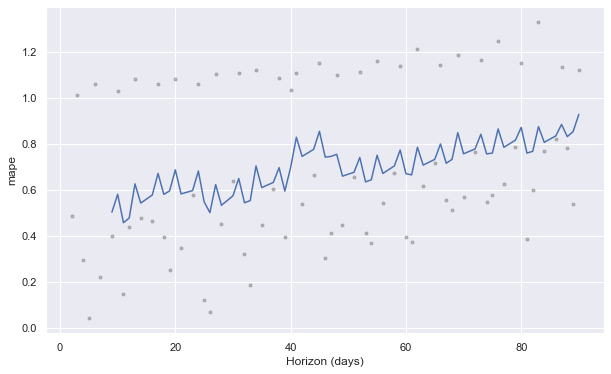

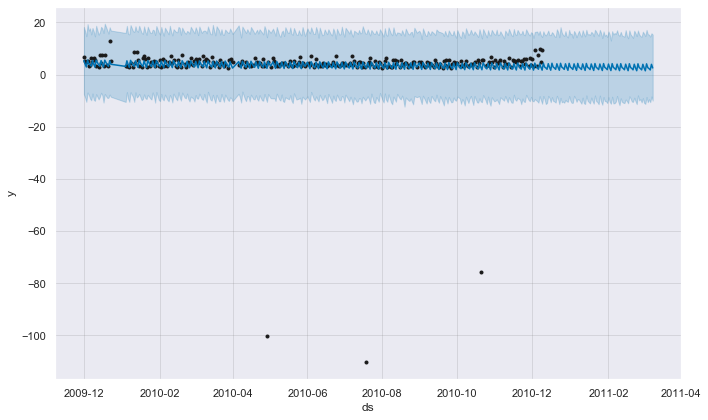

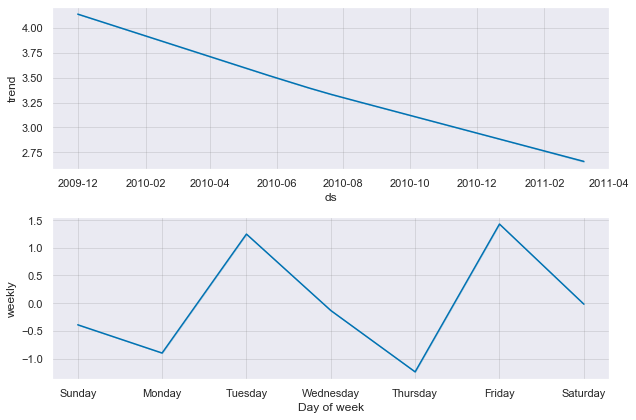

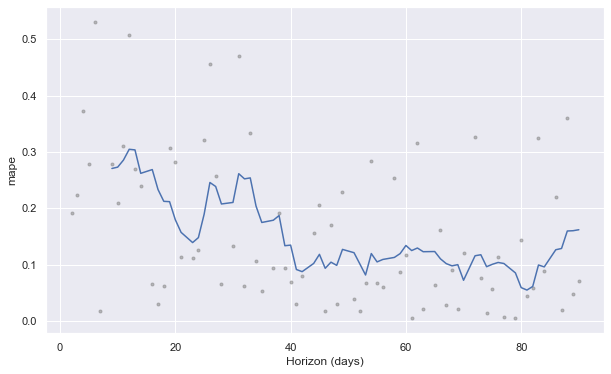

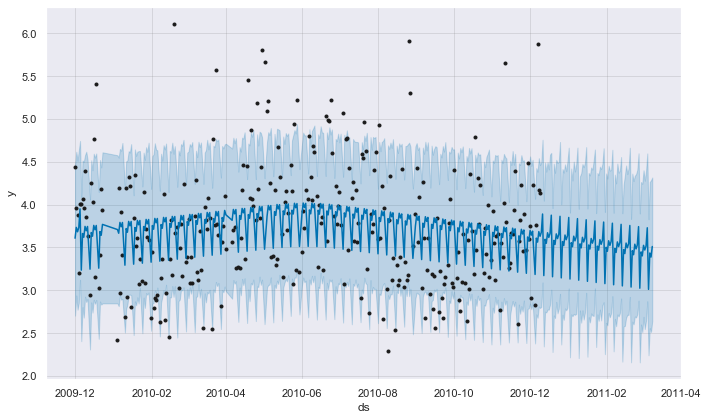

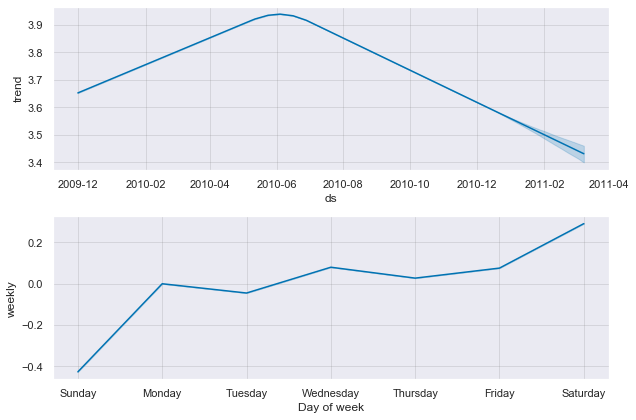

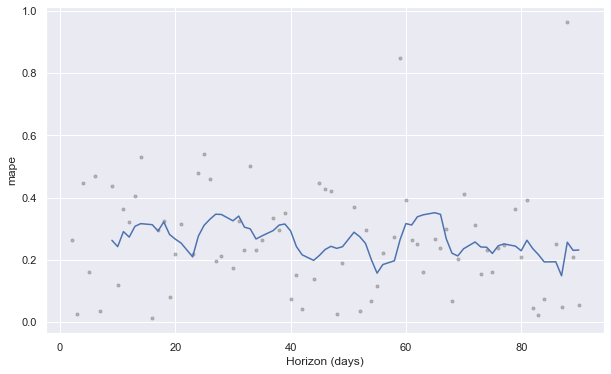

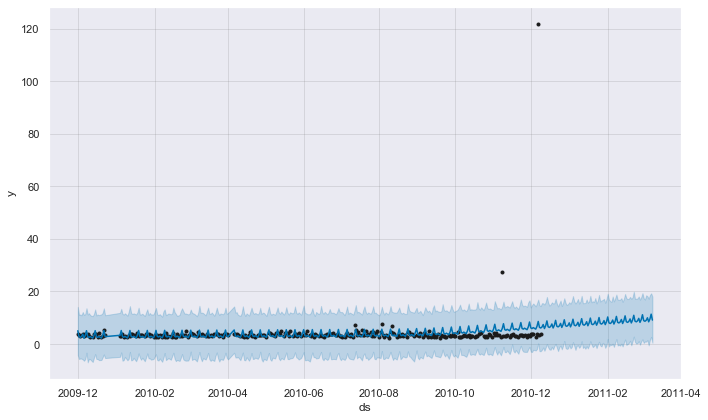

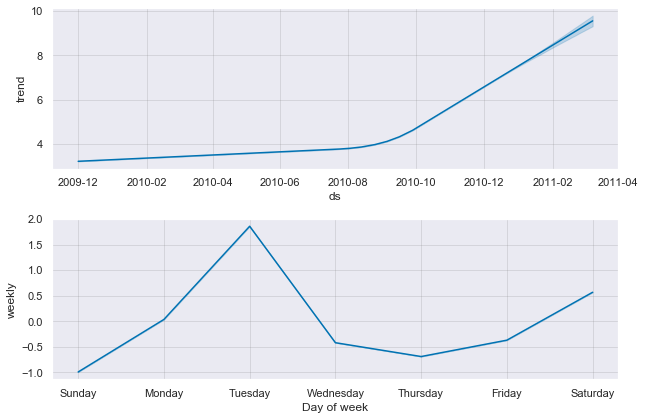

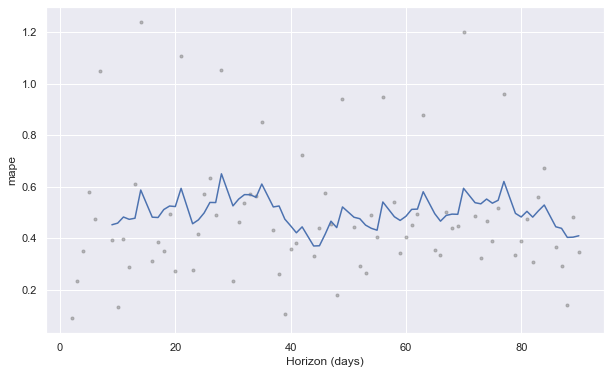

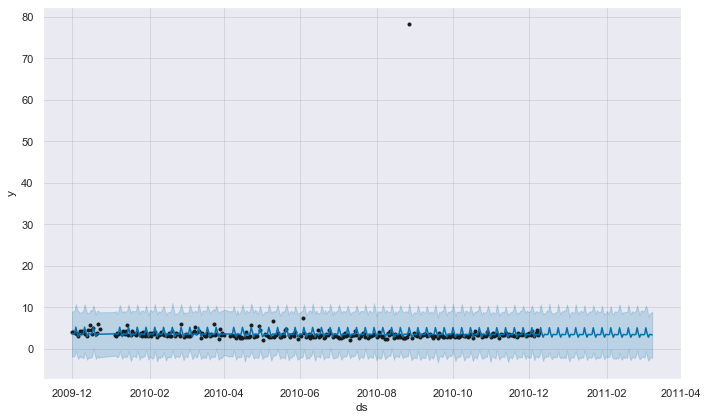

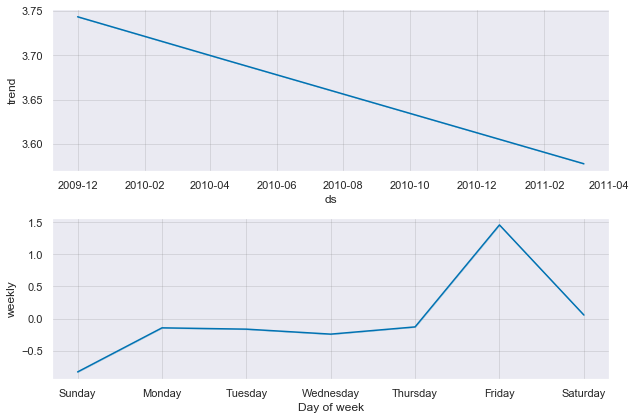

In [258]:
for i in list_topics:
    create_prediction(i)

### LSTM